BloomTech Data Science

*Unit 2, Sprint 2, Module 4*

---

#Project: Classification Metrics

This project will focus on creating and improving a model for the Tanzania Water Pump dataset. The goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.


# I. Wrangle Data

In [ ]:
%%capture
!pip install category_encoders==2.*
!pip install pandas_profiling ==2.*

In [ ]:
from category_encoders import OrdinalEncoder
from pandas_profiling import ProfileReport

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

import plotly.express as px

In [ ]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Working directory
%cd /content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge

/content/gdrive/My Drive/Kaggle/bloomtech-water-pump-challenge


In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    return df

In [ ]:
df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv')

In [ ]:
# EDA
print(df.shape, X_test.shape)
df.head()

(47519, 30) (11880, 29)


,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,NaN,Internal,Manyara,21,1.0,160.0,...,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
510.0,NaN,NaN,35.510074,-5.724555,NaN,Internal,Dodoma,1,6.0,NaN,...,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
14146.0,NaN,NaN,32.499866,-9.081222,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,...,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional
47410.0,NaN,NaN,34.060484,-8.830208,NaN,Rufiji,Mbeya,12,7.0,NaN,...,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
1288.0,300.0,1023.0,37.032690,-6.040787,NaN,Wami / Ruvu,Morogoro,5,1.0,120.0,...,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional


In [ ]:
# See unique values for the status group column
df['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

# II. Split Data


In [ ]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Sanity Check 
assert len(X_train) + len(X_val) == len(X)

# III. Establish Baseline

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


# IV. Build Models


In [ ]:
# Build pipeline
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25, n_jobs=-1, random_state=42))

# Fit model on training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                

# V. Check Metrics



In [ ]:
training_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9931079836906485
Validation Accuracy Score: 0.7910353535353535


**Insights:** There is a little bit of distance between the scores from the training and test sets, but the accuracy of the model seems good. 

The accuracy scores tells us that 79.10% of the samples in our test set were accurately predicted. However, these scores don't give us any information on where the model went wrong. 

If we want to know whether the model had a problem in predicting the positive or negative samples we need to use a confusion matrix which will help us identify patterns and misclassification.

## Confusion matrix for the model, using validation data.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


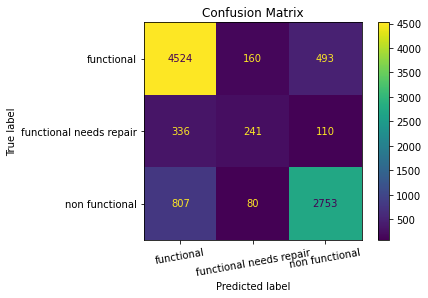

In [ ]:
# Plot 3x3 confusion matrix

plot_confusion_matrix(
    model,
    X_val,
    y_val,
    xticks_rotation='10'
)
plt.title("Confusion Matrix");

**Insights:** 
- We can see there are three possible predicting classes for the water pumps (functional, functional needs repair and non functional). 
- The classifier predicted "functional" 5,667 times. It predicted "functional needs repair" 481 times. And, "non functional" was predicted 3,356 times.
- In reality, 5,177 water pumps are functional, 687 need repairs and 3,640 are non functional.
- The diagonal values represent the number of water pumps for which the predicted label is equal to the true label. These are the classes that our model got right.
- The off-diagonal values indicate mistakes in the predictions.



## Classification report for the model, using validation data.

In [ ]:
# Print classification report 
print(classification_report(y_val,
                      model.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.83      5177
functional needs repair       0.50      0.35      0.41       687
         non functional       0.82      0.76      0.79      3640

               accuracy                           0.79      9504
              macro avg       0.71      0.66      0.68      9504
           weighted avg       0.79      0.79      0.79      9504



**Insights:**
- Precision = When the model predicted that the water pumps were "functional", it was correct about 80% of the times.
-  Recall = The proportion of actual "functional" water pumps that were correctly identified by the model was 87%.

# VI. Tune Model

Adjust the hyperparameters of the model to increase performance. We want to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by BloomTech/Lambda alumn Michael Brady.)

Using the model's `predict_proba` method, we want to identify the observations in the **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Then, we want to put these observations in the DataFrame `X_test_nf`.

In [ ]:
# Model predicted probabilities for 'non-functional' water pumps
model.predict_proba(X_val)[:,-1]

array([0.16, 0.96, 0.84, ..., 0.92, 0.68, 0.72])

In [ ]:
{'y_val': y_val, 
        'y_pred_proba': model.predict_proba(X_val)[:, -1]}

{'y_val': id
 8492.0     functional needs repair
 16772.0             non functional
 19506.0                 functional
 40301.0             non functional
 61519.0                 functional
                     ...           
 48746.0             non functional
 28999.0                 functional
 41195.0             non functional
 63703.0    functional needs repair
 65681.0             non functional
 Name: status_group, Length: 9504, dtype: object,
 'y_pred_proba': array([0.16, 0.96, 0.84, ..., 0.92, 0.68, 0.72])}

In [ ]:
# Apply the predicted probabilities information to a dataframe
data = {'y_val': y_val, 
        'y_pred_proba': model.predict_proba(X_val)[:, -1]} # filtering 'non functional' pumps

result = pd.DataFrame(data)

mask = result['y_pred_proba'] > 0.95

X_test_nf = result[mask]
X_test_nf

,y_val,y_pred_proba
id,,
16772.0,non functional,0.96
4125.0,non functional,0.96
12693.0,non functional,1.00
20316.0,non functional,0.96
47371.0,non functional,0.96
...,...,...
24396.0,non functional,0.96
64589.0,non functional,1.00
3405.0,non functional,1.00


In [ ]:
# Merge X_test_nf with the original data set along the index

final_df = X_test_nf.merge(df, right_index=True, left_index=True)
large_pop_pumps = final_df.sort_values(by='population', ascending=False).head(100)

In [ ]:
large_pop_pumps.sample(5)

,y_val,y_pred_proba,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
4125.0,non functional,0.96,NaN,1907.0,31.670500,-8.135057,NaN,Lake Rukwa,Rukwa,15,...,never pay,soft,good,dry,river,river/lake,surface,communal standpipe,communal standpipe,non functional
32851.0,non functional,1.00,50.0,NaN,36.964946,-6.213482,NaN,Wami / Ruvu,Morogoro,5,...,per bucket,salty,salty,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
49324.0,non functional,1.00,NaN,262.0,38.899726,-10.096954,NaN,Ruvuma / Southern Coast,Lindi,80,...,never pay,salty,salty,insufficient,shallow well,shallow well,groundwater,other,other,non functional
21538.0,non functional,1.00,NaN,1196.0,33.033595,-2.017418,NaN,Lake Victoria,Mwanza,19,...,never pay,soft,good,insufficient,lake,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
15465.0,functional needs repair,0.96,NaN,1105.0,36.315825,-4.696482,NaN,Internal,Manyara,21,...,never pay,soft,good,enough,machine dbh,borehole,groundwater,other,other,functional needs repair


# VII. Communicate Results


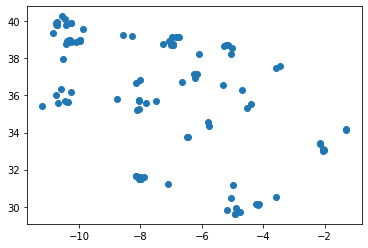

In [ ]:
# Scatter plot with the location of the 100 pumps in X_test_nf
plt.scatter(large_pop_pumps['latitude'], large_pop_pumps['longitude']);

In [ ]:
# Mapbox Scatter Plot
fig = px.scatter_mapbox(large_pop_pumps, lat='latitude', lon='longitude',
                  mapbox_style='satellite', size='population', color='y_val')

fig.update_layout(mapbox_style='open-street-map')
fig.show()